In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import missingno as msno
from sklearn.ensemble import RandomForestRegressor

custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
plt.style.use('dark_background')

%precision 3
%matplotlib inline

#### データの読み込み

In [2]:
df = pd.read_csv("./train.csv", parse_dates=["datetime"])
df_test = pd.read_csv("./test.csv", parse_dates=["datetime"])
data = df.append(df_test, sort=False)

#### feature engineering

In [3]:
data["year"] = data["datetime"].dt.year
data["month"] = data["datetime"].dt.month
data["day"] = data["datetime"].dt.day
data["dayofweek"] = data["datetime"].dt.dayofweek
data["hour"] = data["datetime"].dt.hour

#### RandomForestを使って windowspeed = 0 を穴埋め

In [4]:
pick = ['season', 'weather', 'temp','atemp', 'humidity', 'month', 'year']
reg = RandomForestRegressor()
win0 = data[data["windspeed"] == 0].copy()
winNot0 = data[data["windspeed"] != 0].copy()
reg.fit(X=winNot0[pick], y=winNot0["windspeed"])
win0Value= reg.predict(win0[pick])
win0.loc[:,"windspeed"] = win0Value
data = winNot0.append(win0,sort=False)

#### データ種別の定義

In [5]:
categoricalFeatureNames = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","registered"]
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

#### Train / Test に分割

In [6]:
dataTrain = data[pd.notnull(data["count"])].sort_values(by="datetime")
dataTest = data[~pd.notnull(data["count"])].sort_values(by="datetime")

In [7]:
datatimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsRegistered = dataTrain["registered"]
yLabelCasual = dataTrain["casual"]

#### 不要なデータを削除

In [8]:
dataTrain = dataTrain.drop(dropFeatures,axis=1)
dataTest = dataTest.drop(dropFeatures,axis=1)

#### 評価指標としてRMSLE(Root Mean Squared Log Error)を追加
$RMSLE = \sqrt{\frac{1}{N} \sum^{n}_{i=0}(log(y_i + 1) - log(y'_{i} + 1))^2}$

In [9]:
def rmsle(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y)
        y_ = np.exp(y_)
    
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc = np.sqrt(np.mean((log1 - log2)**2))
    return calc
        

In [10]:
def mse(y, y_, convertExp=True):
    return np.sqrt(np.mean(y - y_)**2)

#### Linear Regression Model

In [39]:
class myLinearRegression(object):
    def __init__(self, eta=0.01, n_iter=10, verbose=True):
        self.eta = eta
        self.n_iter = n_iter
        self.verbose = verbose
    
    def fit(self, X, y):
        self.w_ = np.ones(1 + X.shape[1])
        self.cost = []
        for i in range(self.n_iter):
            output = np.dot(X, self.w_[1:] + self.w_[0])
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors*2).sum() / 2.0
            if self.verbose == True and i%10 == 0:
                print("ITER=[{}]: ERROR:[{}]".format(i, cost))
            
            self.cost.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def predict(self, X):
        return self.net_input(X)

In [52]:
y[:, np.newaxis].shape

(10886, 1)

In [57]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_Y = StandardScaler()
X_std = sc_X.fit_transform(dataTrain)
y_std = sc_Y.fit_transform(y[:, np.newaxis]).flatten()

In [58]:
mylr = myLinearRegression(eta=0.00001, n_iter=100)

In [60]:
# mylr.fit(X_std, y_std)

ITER=[0]: ERROR:[-4.4674379751086235e-09]
ITER=[10]: ERROR:[-1.7853380995802581e-09]
ITER=[20]: ERROR:[-8.990355127025396e-10]
ITER=[30]: ERROR:[-5.75596459384542e-10]
ITER=[40]: ERROR:[-4.4943249122297857e-10]
ITER=[50]: ERROR:[-3.9696601561445277e-10]
ITER=[60]: ERROR:[-3.7334757507778704e-10]
ITER=[70]: ERROR:[-3.6018832361151e-10]
ITER=[80]: ERROR:[-3.532818482199218e-10]
ITER=[90]: ERROR:[-3.48791218129918e-10]


In [61]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import statsmodels.api as sm
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
y = np.log1p(yLabels)
lr = LinearRegression(normalize=True,n_jobs=-1)
lr.fit(X=X_std[:1000], y=y_std[:1000])
pred = lr.predict(dataTrain)
lr_rmsle = rmsle(y, pred, True)
print("RMSLE = {}".format(lr_rmsle))

#### Ridge Regression

In [27]:
y = np.log1p(yLabels)
lr_ridge = Ridge()
ridge_params = {'max_iter': [3000], 
                'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_score = metrics.make_scorer(rmsle, greater_is_better=False)
# mse_score = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

In [29]:
grid_ridge_m = GridSearchCV(lr_ridge, ridge_params, scoring=rmsle_score, cv=5)
grid_ridge_m.fit(dataTrain, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

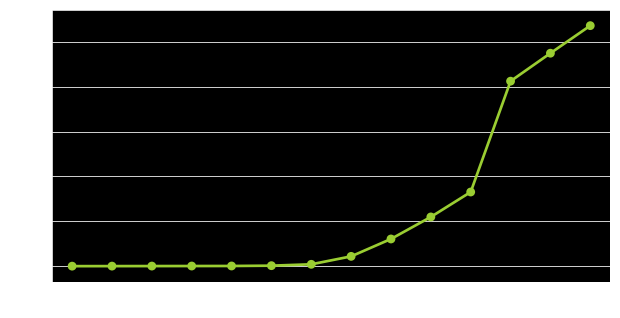

In [30]:
alphas = pd.DataFrame(grid_ridge_m.grid_scores_)['parameters'].apply(lambda s: s['alpha'])
scores = pd.DataFrame(grid_ridge_m.grid_scores_)['mean_validation_score']*-1
plt.figure(figsize=(10,5))
sns.pointplot(alphas, scores,color="yellowgreen")

In [32]:
pred = grid_ridge_m.predict(dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(y),np.exp(pred),False))

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9778186102848435
